In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [2]:
#Parameters

cmap = plt.get_cmap('nipy_spectral')
cmap.set_bad('burlywood')

# H = 24 #One day in hours

# #Ariane parameters
# tunit= 3600

# outint = 20 * 60 # 20 min in seconds

# pph = int(tunit / outint) #points per hour

# lmt = 1896 #points per particle


# #RUN parameters


# basedir = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/"

# plotsdir = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/plots"

filesdir = "/ocean/gsgarbi/selected_days/"


In [3]:
def create_array(filesdir, nday):
    
    dirs = os.listdir(filesdir)
    


    dirs.sort()

    pts = []

    for i in dirs:

        if str(nday)+"d" in i and i[:4] == "2016": #select length



            array = np.load(open(filesdir + i, 'rb'))

            pts.append(array)

    pts = np.array([i for sublist in pts for i in sublist])
    
    print (len(pts))

    
    return pts

In [8]:
def plot(points, title = 'title', picname = "noname"):
    
    Iona = (-123.30898284912109, 49.187351226806641)
    S15 = (-123.3114, 49.130412)
    S16 = (-123.317415, 49.1214)
    xl=(-126.2,-122.2)
    yl=(47.1,51)



    #prepare plot and constants
    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)
#     np.shape(points)
    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]
    griddata.shape
#     np.shape(points)[0]

    griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],bins=[100,200],range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    

    fig, axs = plt.subplots(1,1,figsize=(9,8))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0, vmax = vmax)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    
    axs.set_title( title + "\n Total of trajectories: {}".format( int(np.sum(griddata)) ) )
    
    el = Ellipse((2, -1), 0.5, 0.5)

    axs2.annotate(
            "IONA",
            xy=(Iona[0], Iona[1]), xytext=(50, 10),
            textcoords='offset points', ha='left', va='bottom', color = (0.937, 0.439, 0.043),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1,1,1), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1"))

    fb=nc.Dataset('/ocean/gsgarbi/revised_notebooks/ncfiles/bathymetry_201702.nc')

    B = np.copy(fb.variables ['Bathymetry'])
    LON = np.copy(fb.variables ['nav_lon'])
    LAT = np.copy(fb.variables ['nav_lat'])
    fb.close()
   
    axs2.contour(LON,LAT,B,levels=[50,], colors = ['w',], linewidths = [0.8,])
        
    xc = np.mean(points[:,1])
    yc = np.mean(points[:,2])
    xs = np.std(points[:,1])
    ys = np.std(points[:,2])
    
    axs2.plot(xc,yc,"kx", ms = 10)
    
    axs.set_title( title + "\n Total of trajectories: {} \n".format( 
        int(np.sum(griddata)) ) + "STD: ({}, {})".format(round(xs,2), 
                                                         round(ys,2)) +
                 " Centroid: ({}, {})".format (round(xc, 2), round(yc, 2))
                                                        )
    
    
    plt.savefig(picname, transparent = True)

25486
start:  2017-06-26 16:13:58.779660


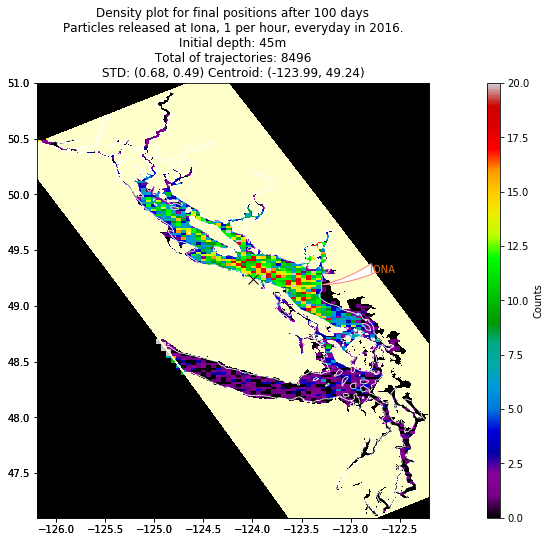

start:  2017-06-26 16:13:59.822027


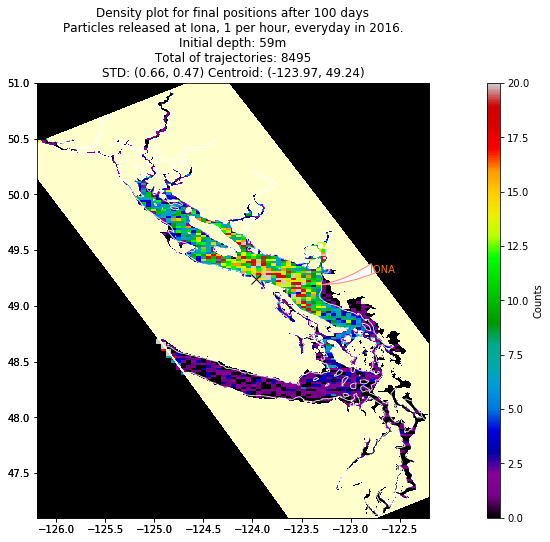

start:  2017-06-26 16:14:00.839946


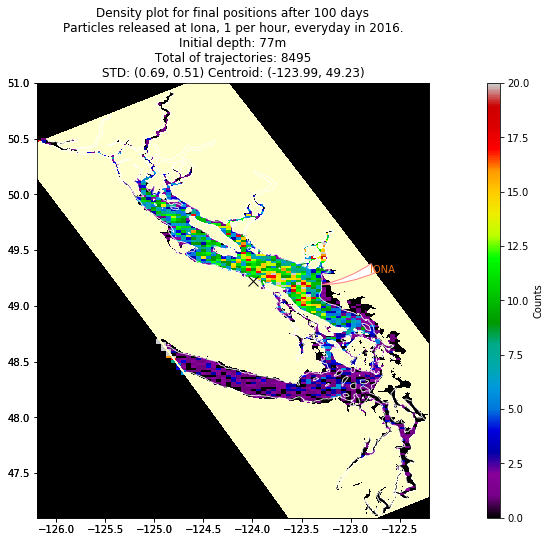

In [12]:
plt.clf()

nday = 100

year1 = []
year2 = []
year3 = []

if nday == 50:
    vmax = 40
    
if nday == 100:
    vmax = 20



array = create_array(filesdir, nday)

year1 = array[0::3]
year2 = array[1::3]
year3 = array[2::3]


points = np.array(year1) #back to original name. convert to np.array

depth = 45

title = (
    "Density plot for final positions after {} days\n"
    "Particles released at Iona, 1 per hour, everyday in 2016.\n"
    "Initial depth: {}m".format(nday, depth)
)

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}d_{}m.png".format(nday, depth)



f45 = plot (year1, title, picname)
plt.show()

points = np.array(year2) #back to original name. convert to np.array

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}d_{}m.png".format(nday, depth)
depth = 59

title = (
    "Density plot for final positions after {} days\n"
    "Particles released at Iona, 1 per hour, everyday in 2016.\n"
    "Initial depth: {}m".format(nday, depth)
)

f59 = plot (points, title, picname)
plt.show()

points = np.array(year3) #back to original name. convert to np.array

depth = 77

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}d_{}m.png".format(nday, depth)

title = (
    "Density plot for final positions after {} days\n"
    "Particles released at Iona, 1 per hour, everyday in 2016.\n"
    "Initial depth: {}m".format(nday, depth)
)

f77 = plot (points, title, picname)
plt.show()


start:  2017-06-26 15:57:34.407944


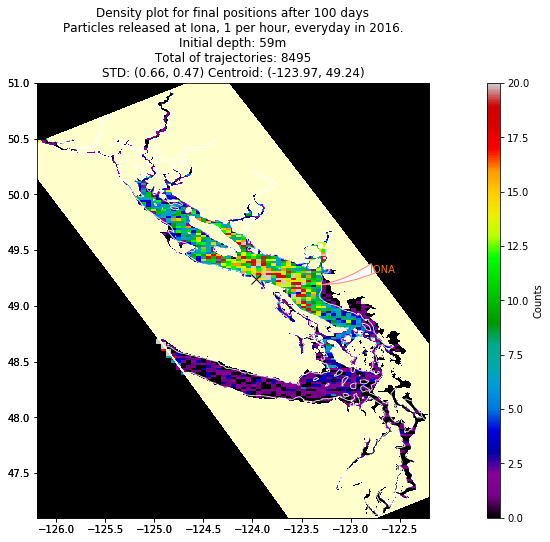

In [6]:
points = np.array(year2) #back to original name. convert to np.array

picname = "/ocean/gsgarbi/analysis-giorgio/2017apr20_presentation/{}d_{}m".format(nday, depth)
depth = 59

title = (
    "Density plot for final positions after {} days\n"
    "Particles released at Iona, 1 per hour, everyday in 2016.\n"
    "Initial depth: {}m".format(nday, depth)
)

f59 = plot (points, title, picname)

start:  2017-06-26 15:57:35.449513


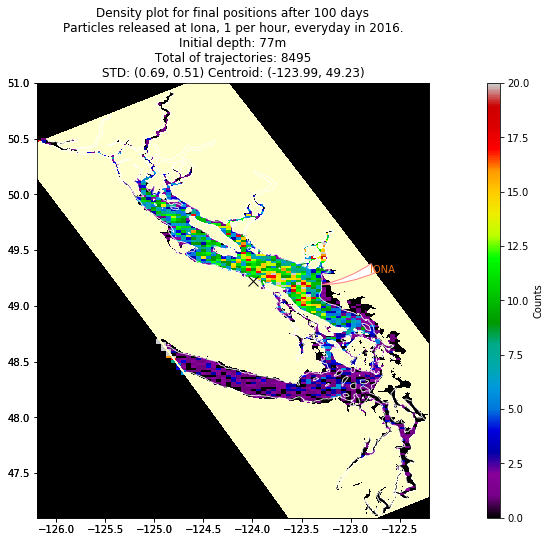

In [7]:
points = np.array(year3) #back to original name. convert to np.array

depth = 77

picname = "/ocean/gsgarbi/analysis-giorgio/2017apr20_presentation/{}d_{}m".format(nday, depth)

title = (
    "Density plot for final positions after {} days\n"
    "Particles released at Iona, 1 per hour, everyday in 2016.\n"
    "Initial depth: {}m".format(nday, depth)
)

f77 = plot (points, title, picname)